<a href="https://colab.research.google.com/github/Agil0509/Deep-Learning/blob/main/ViT_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Data

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
!nvidia-smi

Tue Sep  2 13:26:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install torchinfo

In [4]:
import torch
import torchvision
import matplotlib.pyplot  as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import zipfile
import requests
from pathlib import Path


data_path = Path('data/')
image_path = data_path / 'piza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} is exist')
else:
    print(f"Didint exist {image_path}, creating one ...")
    image_path.mkdir(parents = True, exist_ok = True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Didint exist data/piza_steak_sushi, creating one ...
Unzipping pizza, steak, sushi data...


In [7]:
image_path = "/content/data/piza_steak_sushi"
train_dir = image_path + "/train"
test_dir  = image_path + "/test"

In [8]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'manual transforms {manual_transforms}')

manual transforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

train_data = datasets.ImageFolder(root= train_dir,
                                  transform = manual_transforms)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = manual_transforms)

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [10]:
train_dataloader = DataLoader(train_data,
                              batch_size = 32,
                              shuffle = True,
                              num_workers = os.cpu_count())
test_dataloader = DataLoader(test_data,
                             batch_size = 32,
                             shuffle = False,
                             num_workers = os.cpu_count())

test_dataloader

In [11]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [12]:
image, label = image_batch[0], label_batch[0]
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

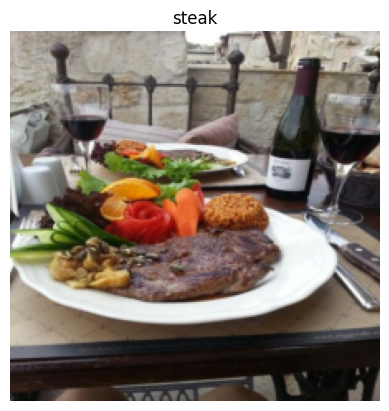

In [13]:
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
plt.title(class_names[label])
plt.show()

#ViT Paper - Equations

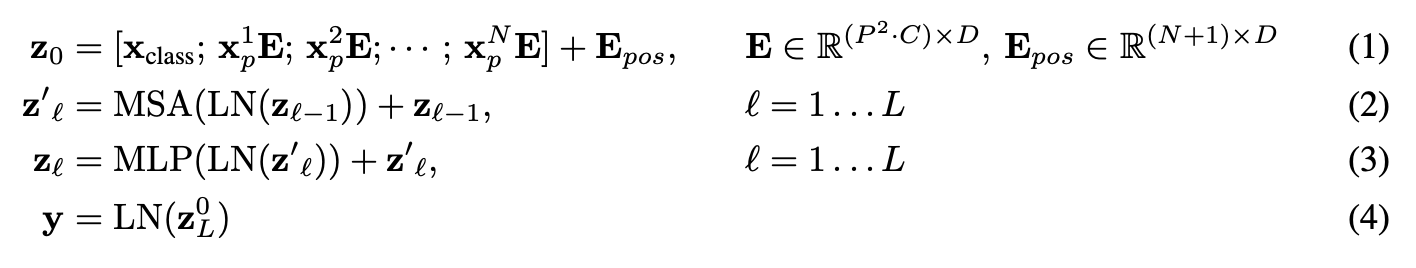

##Equation 1 - Split image into patches, create class, postion and patch embedding

In [14]:
height = 224
width = 224
channels = 3
patch_size = 16

number_of_patches = int(height*width/patch_size**2)
number_of_patches

196

In [15]:
input_shape = image.shape
embedding_layer_output_shape = (number_of_patches, patch_size**2*channels)

print(f'input shape --> {input_shape}; output shape {embedding_layer_output_shape}')

input shape --> torch.Size([3, 224, 224]); output shape (196, 768)


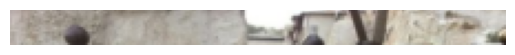

In [16]:
image_permuted = image.permute((1,2,0))
patch_size = 16

plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False)
plt.show()

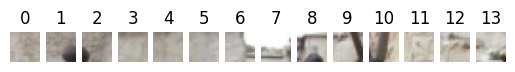

In [17]:
image_top_view = image_permuted[:patch_size, :, :]
for i in range(14):
    plt.subplot(1, 14, i+1)
    plt.imshow(image_top_view[:, i*16:i*16+16, :])
    plt.title(i)
    plt.axis(False)

plt.show()

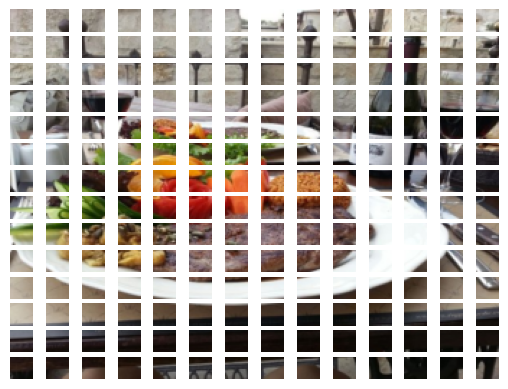

In [18]:
a = 0
for i in range(14):
    for j in range(14):
        a+= 1
        plt.subplot(14, 14, a)
        plt.imshow(image_permuted[i*16: i*16 + 16, j*16: j*16 + 16, :])
        plt.xlabel(i+1)
        plt.ylabel(j+1)
        plt.axis(False)
plt.show()

###Creating image patches with torch.nn.Conv2d()

In [19]:
patch_size = 16
conv2d = torch.nn.Conv2d(in_channels = 3,
                         out_channels = 768,
                         kernel_size = patch_size,
                         stride=patch_size)

image_out_conv = conv2d(image.unsqueeze(0))
image_out_conv.shape

torch.Size([1, 768, 14, 14])

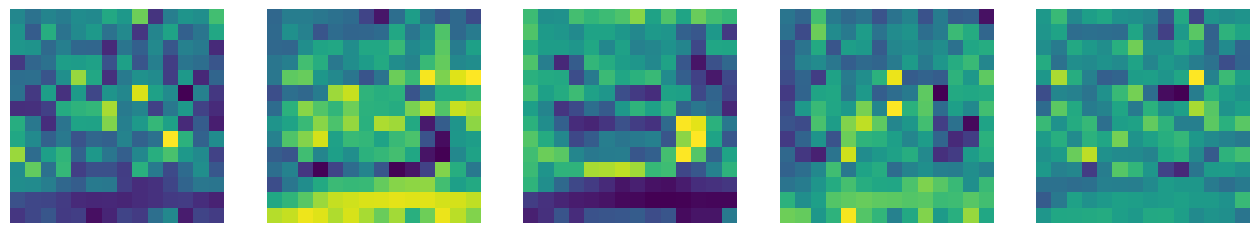

In [20]:
import random

random_indexes = random.sample(range(0,768), k = 5)
plt.figure(figsize = (16, 16))
for i, v in enumerate(random_indexes):
    plt.subplot(1, 5, i+1)
    img_conv_feature_map = image_out_conv[:, v, :, :]
    plt.imshow(img_conv_feature_map.squeeze().detach().numpy())
    plt.axis(False)

In [21]:
single_feature_map = image_out_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.5577,  0.3946,  0.4998,  0.5344,  0.5775,  0.5988,  0.6356,
            0.7926,  0.6445,  0.5089,  0.4649,  0.6244,  0.6006,  0.6521],
          [ 0.5752,  0.4337,  0.5265,  0.3902,  0.4945,  0.5396,  0.3815,
            0.4515,  0.0823,  0.4573,  0.3847,  0.1594,  0.4424,  0.3661],
          [ 0.5242,  0.5020,  0.5187,  0.4058,  0.3943,  0.5546,  0.3961,
            0.3677,  0.2918,  0.4556,  0.2830,  0.2553,  0.4525,  0.2321],
          [ 0.4159,  0.2522,  0.2043,  0.6155,  0.5997,  0.6385,  0.4991,
            0.5188,  0.3108,  0.4640,  0.2230,  0.0839,  0.2546,  0.2870],
          [ 0.4807,  0.4291,  0.5250,  0.1675,  0.3286,  0.3959,  0.3816,
            0.4983,  0.6345,  0.5866,  0.2449,  0.2033,  0.0720,  0.2683],
          [ 0.6241,  0.3675,  0.5273,  0.3304,  0.2207,  0.1052,  0.3067,
            0.2079,  0.5016,  0.5520,  0.6086,  0.3080,  0.4235,  0.1730],
          [ 0.4097,  0.4001,  0.0685,  0.2930,  0.0417,  0.1028,  0.2695,
            0.2049,  0.1526,  0.

In [22]:
flatten = torch.nn.Flatten(start_dim = 2,
                           end_dim = 3)

image_out_conv_flattened = flatten(image_out_conv)
image_out_conv_flattened.shape

torch.Size([1, 768, 196])

In [23]:
image_out_conv_flattened_permuted = image_out_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
image_out_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

In [24]:
single_flattened_feature_map = image_out_conv_flattened_permuted[:, :, 0]
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False)
single_flattened_feature_map.shape

torch.Size([1, 196])

In [25]:
class PatchEmedding(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 embedding_dim = 768,
                 patch_size = 16):
        super().__init__()

        self.patcher = torch.nn.Conv2d(in_channels = in_channels,
                                       out_channels = embedding_dim,
                                       kernel_size = patch_size,
                                       stride = patch_size,
                                       padding = 0)

        self.flatten = torch.nn.Flatten(start_dim = 2,
                                        end_dim = 3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'image size divisible patch size --->{image_resolution} ---> {patch_size}'
        x_patched = self.patcher(x)
        x_flattend = self.flatten(x_patched)
        return x_flattend.permute((0,2,1))

In [26]:
patchify = PatchEmedding(in_channels = 3,
                        embedding_dim = 768,
                         patch_size = 16)

patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [27]:
summary(PatchEmedding())

Layer (type:depth-idx)                   Param #
PatchEmedding                            --
├─Conv2d: 1-1                            590,592
├─Flatten: 1-2                           --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0

In [28]:
16*16*3*768+768

590592

In [29]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones((batch_size, 1, embedding_dimension)),
                           requires_grad = True)

class_token[:, :, :10], class_token.requires_grad

(tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>),
 True)

In [30]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1)   #(batch, number of patch, embed dim)
print(patch_embedded_image_with_class_embedding.shape)

torch.Size([1, 197, 768])


In [31]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2308,  0.3146,  0.1788,  ...,  0.3211,  0.0363,  0.3273],
         [ 0.2422,  0.2919, -0.0353,  ...,  0.2233, -0.0840,  0.2432],
         ...,
         [ 0.0487, -0.0128,  0.0195,  ...,  0.0504,  0.0331, -0.0042],
         [-0.0078,  0.1331,  0.1341,  ...,  0.0755,  0.1030,  0.0087],
         [-0.1886,  0.3407,  0.1378,  ...,  0.2151, -0.0331,  0.2455]]],
       grad_fn=<CatBackward0>)

In [32]:
number_of_patches = int(height*width / patch_size**2)
embedding_dimension = patch_embedded_image.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension), requires_grad = True)

position_embedding.shape

torch.Size([1, 197, 768])

In [33]:
position_embedding[:, :10, :10], position_embedding.requires_grad

(tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>),
 True)

In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2308, 1.3146, 1.1788,  ..., 1.3211, 1.0363, 1.3273],
         [1.2422, 1.2919, 0.9647,  ..., 1.2233, 0.9160, 1.2432],
         ...,
         [1.0487, 0.9872, 1.0195,  ..., 1.0504, 1.0331, 0.9958],
         [0.9922, 1.1331, 1.1341,  ..., 1.0755, 1.1030, 1.0087],
         [0.8114, 1.3407, 1.1378,  ..., 1.2151, 0.9669, 1.2455]]],
       grad_fn=<AddBackward0>)

###All equation in one cell

In [35]:
patch_size = 16
hight, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

patch_embedding_layer = PatchEmedding(in_channels = 3,
                                      embedding_dim = 768,
                                      patch_size = patch_size)

patch_embedding = patch_embedding_layer(x)

batch_size = patch_embedding.shape[0]
number_of_patches = patch_embedding.shape[1]
embedding_dimession = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
patch_embedding_class_token.shape


position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimession))
patch_and_position_embedding = position_embedding + patch_embedding_class_token
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.5362, 0.9857, 1.1204,  ..., 1.6756, 0.6619, 1.2579],
         [1.4381, 0.9615, 1.1093,  ..., 1.5200, 0.6164, 1.1543],
         ...,
         [1.0066, 1.0417, 1.0413,  ..., 1.0336, 0.8948, 1.0280],
         [1.0630, 0.9946, 1.0316,  ..., 1.0465, 0.9629, 1.0786],
         [1.1812, 1.1564, 1.2620,  ..., 1.3828, 1.0922, 1.1497]]],
       grad_fn=<AddBackward0>)

##Equation 2 - Multi - Head Self Attention (MSA)

In [36]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim = 768,
                 num_heads = 12,
                 attn_dropout = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        self.multihead_atnn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_atnn(query = x,
                                            key = x,
                                            value = x,
                                            need_weights = False)
        return attn_output


In [37]:
multihead_self_attention = MultiheadSelfAttentionBlock(embedding_dim = 768,
                                                       num_heads = 12)
patched_image_through_msa_block = multihead_self_attention(patch_and_position_embedding)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [38]:
summary(multihead_self_attention)

Layer (type:depth-idx)                             Param #
MultiheadSelfAttentionBlock                        --
├─LayerNorm: 1-1                                   1,536
├─MultiheadAttention: 1-2                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0

##Equation 3 - Multilayer Perceptron (MLP)

In [39]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim = 768,
                 mlp_size = 3072,
                 dropout = 0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p = dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [40]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 12,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_mlp_block.shape

torch.Size([1, 197, 768])

In [41]:
summary(mlp_block)

Layer (type:depth-idx)                   Param #
MLPBlock                                 --
├─LayerNorm: 1-1                         1,536
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       9,228
│    └─GELU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       9,984
│    └─Dropout: 2-5                      --
Total params: 20,748
Trainable params: 20,748
Non-trainable params: 0

#Create the Transformer Encoder

In [42]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim = 768,
                 mlp_size = 3072,
                 num_heads = 12,
                 mlp_dropout = 0.1,
                 attn_dropout = 0):
        super().__init__()

        self.msa = MultiheadSelfAttentionBlock(embedding_dim,
                                               num_heads,
                                               attn_dropout)
        self.mlp = MLPBlock(embedding_dim,
                            mlp_size,
                            mlp_dropout)

    def forward(self, x):
        x = self.msa(x) + x  # skip connection
        x = self.mlp(x) + x  # skip connevtion

        return x

In [43]:
transformer_encoder_block  = TransformerEncoderBlock(embedding_dim=768,
                                          mlp_size = 3072,
                                          num_heads = 12,
                                          mlp_dropout = 0.1,
                                          attn_dropout = 0)

patched_image_through_vit = transformer_encoder_block (patch_and_position_embedding)
patched_image_through_vit.shape

torch.Size([1, 197, 768])

In [44]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_atnn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [45]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             dim_feedforward = 3072,
                                                             nhead = 12,
                                                             dropout = 0.1,
                                                             activation = 'gelu',
                                                             batch_first = True,
                                                             norm_first = True)



In [46]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [47]:
class ViT(nn.Module):
    def __init__(self,
                 img_size = 224,
                 in_channels = 3,
                 patch_size = 16,
                 num_transformer_layers = 12,
                 embedding_dim = 768,
                 mlp_size = 3072,
                 num_heads = 12,
                 attn_dropout = 0,
                 mlp_dropout = 0.1,
                 embedding_dropout = 0.1,
                 num_classes = 1000):
        super().__init__()

        assert img_size % patch_size == 0, f'image size must be diversible to patch'

        self.number_of_patches = int(img_size**2/patch_size**2)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad = True)
        self.position_embedding = nn.Parameter(torch.randn(1, self.number_of_patches + 1, embedding_dim), requires_grad = True)
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)
        self.patch_embedding = PatchEmedding(in_channels,
                                             embedding_dim,
                                             patch_size)
        self.transformer_encoder = nn.Sequential(* [TransformerEncoderBlock(embedding_dim,
                                                                            mlp_size,
                                                                            num_heads,
                                                                            mlp_dropout,
                                                                            attn_dropout) for _ in range(num_transformer_layers)])
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features = embedding_dim,
                      out_features = num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim = 1)
        x = x + self.position_embedding
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifer(x[:, 0])

        return x

In [48]:
batch_size = 32
class_token_embedding_single = nn.Parameter(torch.randn(1, 1, embedding_dimension))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f'Shape of class_token_embedding_single : {class_token_embedding_single.shape}')
print(f'Shape of class_token_embedding_expanded : {class_token_embedding_expanded.shape}')

Shape of class_token_embedding_single : torch.Size([1, 1, 768])
Shape of class_token_embedding_expanded : torch.Size([32, 1, 768])


In [49]:
torch.manual_seed(42)

random_image_tensor = torch.randn(1, 3, 224, 224)

vit  = ViT(num_classes = len(class_names))
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [50]:
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmedding (patch_embedding)                            [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

#Training out ViT model

##Creating train_step() and test_step() functions and train() to combine them

In [51]:
import torch
from tqdm.auto import tqdm


def train_step(model, dataloader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / X.shape[0]

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
            test_acc += (y_pred_class == y).sum().item() / len(y)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


def train(model, train_dataloader, test_dataloader,
          optimizer, loss_fn, epochs, device):

    results = {'train_loss' : [],
              'train_acc' : [],
              'test_loss' : [],
              'test_acc' : []}

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)


        print(f'epoch ---> {epoch+1} |'
              f'train_loss ---> {train_loss:.4f} |'
              f'train_acc  ---> {train_acc:.4f} |'
              f'test_loss  ---> {test_loss:.4f} |'
              f'test_acc   ---> {test_acc:.4f} |')


        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [52]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 3e-3,
                             betas = (0.9, 0.999),
                             weight_decay = 0.3)

torch.manual_seed(42)

result = train(vit, train_dataloader, test_dataloader, optimizer, loss_fn, epochs = 10, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch ---> 1 |train_loss ---> 5.1949 |train_acc  ---> 0.3633 |test_loss  ---> 5.1213 |test_acc   ---> 0.2604 |
epoch ---> 2 |train_loss ---> 1.9517 |train_acc  ---> 0.3320 |test_loss  ---> 1.6205 |test_acc   ---> 0.2604 |
epoch ---> 3 |train_loss ---> 1.2073 |train_acc  ---> 0.4570 |test_loss  ---> 1.7585 |test_acc   ---> 0.2604 |
epoch ---> 4 |train_loss ---> 1.2482 |train_acc  ---> 0.2969 |test_loss  ---> 1.3214 |test_acc   ---> 0.1979 |
epoch ---> 5 |train_loss ---> 1.1331 |train_acc  ---> 0.4297 |test_loss  ---> 1.2293 |test_acc   ---> 0.2604 |
epoch ---> 6 |train_loss ---> 1.1787 |train_acc  ---> 0.3125 |test_loss  ---> 1.2245 |test_acc   ---> 0.1979 |
epoch ---> 7 |train_loss ---> 1.2512 |train_acc  ---> 0.2578 |test_loss  ---> 1.2060 |test_acc   ---> 0.1979 |
epoch ---> 8 |train_loss ---> 1.1147 |train_acc  ---> 0.4258 |test_loss  ---> 1.1859 |test_acc   ---> 0.2604 |
epoch ---> 9 |train_loss ---> 1.1458 |train_acc  ---> 0.3047 |test_loss  ---> 1.0135 |test_acc   ---> 0.5417 |
e

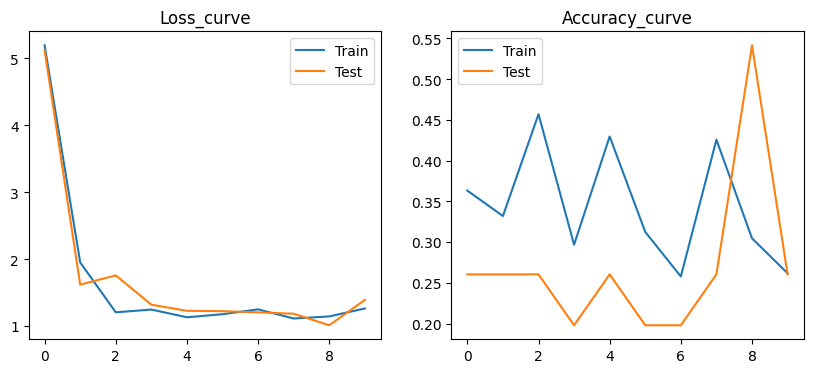

In [54]:
import matplotlib.pyplot as plt

epochs = 10

plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(range(epochs), result['train_loss'], label = 'Train')
plt.plot(range(epochs), result['test_loss'], label = 'Test')
plt.title("Loss_curve")
plt.legend()
# plt.axis(False)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), result['train_acc'], label = 'Train')
plt.plot(range(epochs), result['test_acc'], label = 'Test')
plt.legend()
plt.title('Accuracy_curve')
# plt.axis(False)

plt.show()

#Using pretrained ViT model on the same dataset

In [55]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:24<00:00, 13.9MB/s]


In [56]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [57]:
pretrained_vit_transform = pretrained_vit_weights.transforms()
pretrained_vit_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [58]:
train_dir, test_dir

('/content/data/piza_steak_sushi/train', '/content/data/piza_steak_sushi/test')

In [59]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_data = ImageFolder(train_dir,
                         pretrained_vit_transform)

test_data = ImageFolder(root = test_dir,
                        transform = pretrained_vit_transform)

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [60]:
train_dataloader_pretrained = DataLoader(train_data, batch_size = 32, num_workers=os.cpu_count(), shuffle = True)

test_dataloader_pretrained = DataLoader(test_data, batch_size = 32, num_workers=os.cpu_count(), shuffle = False)
train_dataloader_pretrained, test_dataloader_pretrained

(<torch.utils.data.dataloader.DataLoader at 0x7e4da0127380>,
 <torch.utils.data.dataloader.DataLoader at 0x7e4da01243b0>)

In [61]:
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(), lr = 3e-3, betas = (0.9, 0.999))

loss_fn = torch.nn.CrossEntropyLoss()
pretrained_vit_result = train(pretrained_vit, train_dataloader_pretrained, test_dataloader_pretrained, optimizer, loss_fn, epochs = 10, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch ---> 1 |train_loss ---> 0.4683 |train_acc  ---> 0.8672 |test_loss  ---> 0.1987 |test_acc   ---> 0.9384 |
epoch ---> 2 |train_loss ---> 0.1070 |train_acc  ---> 0.9688 |test_loss  ---> 0.1686 |test_acc   ---> 0.9384 |
epoch ---> 3 |train_loss ---> 0.0691 |train_acc  ---> 0.9766 |test_loss  ---> 0.1894 |test_acc   ---> 0.9081 |
epoch ---> 4 |train_loss ---> 0.0438 |train_acc  ---> 0.9922 |test_loss  ---> 0.2020 |test_acc   ---> 0.9081 |
epoch ---> 5 |train_loss ---> 0.0294 |train_acc  ---> 0.9922 |test_loss  ---> 0.1955 |test_acc   ---> 0.9081 |
epoch ---> 6 |train_loss ---> 0.0209 |train_acc  ---> 1.0000 |test_loss  ---> 0.1958 |test_acc   ---> 0.9384 |
epoch ---> 7 |train_loss ---> 0.0158 |train_acc  ---> 1.0000 |test_loss  ---> 0.1905 |test_acc   ---> 0.9280 |
epoch ---> 8 |train_loss ---> 0.0127 |train_acc  ---> 1.0000 |test_loss  ---> 0.1872 |test_acc   ---> 0.9280 |
epoch ---> 9 |train_loss ---> 0.0109 |train_acc  ---> 1.0000 |test_loss  ---> 0.1936 |test_acc   ---> 0.9384 |
e

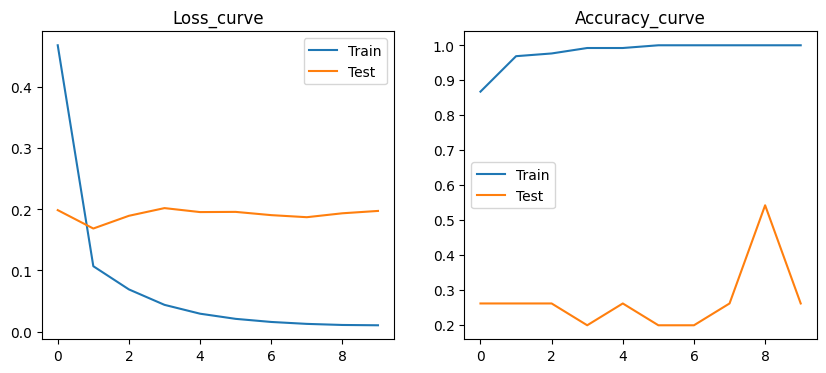

In [62]:
import matplotlib.pyplot as plt

epochs = 10

plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(range(epochs), pretrained_vit_result['train_loss'], label = 'Train')
plt.plot(range(epochs), pretrained_vit_result['test_loss'], label = 'Test')
plt.title("Loss_curve")
plt.legend()
# plt.axis(False)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), pretrained_vit_result['train_acc'], label = 'Train')
plt.plot(range(epochs), result['test_acc'], label = 'Test')
plt.legend()
plt.title('Accuracy_curve')
# plt.axis(False)

plt.show()

##Infrence of pretrained model

In [182]:
def predict(model, path, image, transforms = pretrained_vit_weights.transforms()):

    img = Image.open(image)
    img = transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = (model(img))
        output = torch.argmax(torch.softmax(output, dim = 1), dim = 1)
    plt_img = plt.imread(image)

    plt.imshow(plt_img)
    plt.axis(False)
    plt.title(class_names[output])
    plt.show()


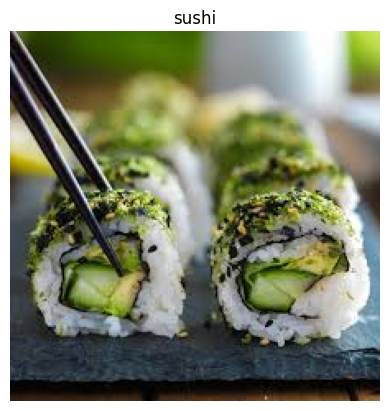

In [183]:
predict(model = pretrained_vit, path = '/content/data/my_model.pth', image = '/content/images.jpg')

## Model's checkpoint save and load

In [63]:
from pathlib import Path

def save_model(model, target_dir, model_name):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents = True,
                          exist_ok = True)

    assert model_name.endswith('.pth') or model_name.endswith('.pt'), "model_name must end with '.pth' or 'pt'"

    model_save_path = target_dir_path/model_name

    torch.save(model.state_dict(), model_save_path)
    print(f'[INFO] model saved {model_save_path}')

In [67]:
save_model(pretrained_vit, 'data', 'my_model.pth')

[INFO] model saved data/my_model.pth


In [74]:
state_dict = torch.load("data/my_model.pth")
model = ViT(num_classes=len(class_names))
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['class_embedding', 'position_embedding', 'patch_embedding.patcher.weight', 'patch_embedding.patcher.bias', 'transformer_encoder.0.msa.layer_norm.weight', 'transformer_encoder.0.msa.layer_norm.bias', 'transformer_encoder.0.msa.multihead_atnn.in_proj_weight', 'transformer_encoder.0.msa.multihead_atnn.in_proj_bias', 'transformer_encoder.0.msa.multihead_atnn.out_proj.weight', 'transformer_encoder.0.msa.multihead_atnn.out_proj.bias', 'transformer_encoder.0.mlp.layer_norm.weight', 'transformer_encoder.0.mlp.layer_norm.bias', 'transformer_encoder.0.mlp.mlp.0.weight', 'transformer_encoder.0.mlp.mlp.0.bias', 'transformer_encoder.0.mlp.mlp.3.weight', 'transformer_encoder.0.mlp.mlp.3.bias', 'transformer_encoder.1.msa.layer_norm.weight', 'transformer_encoder.1.msa.layer_norm.bias', 'transformer_encoder.1.msa.multihead_atnn.in_proj_weight', 'transformer_encoder.1.msa.multihead_atnn.in_proj_bias', 'transformer_encoder.1.msa.multihead_atnn.out_proj.weight', 'transforme